# CH6. 통계적 머신러닝(statistical machine learning)

## 6.1 k-최근접 이웃(KNN, k-nearest neighbors)
1. 특징들이 가자 유사한(즉, 예측변수들이 유사한) k개 레코드를 찾는다.
2. 분류: 이 유사한 레코드들 중에 다수가 속한 클래스가 무엇인지 찾은 후, 새로운 레코드를 그 클래스에 할당
3. 예측(<b>KNN 회귀, KNN regression</b>라고도 함): 유사한 레코드들의 평균을 찾아서 새로운 레코드에 대한 예측값으로 사용한다.

============================================================================================================
###### 용어정리
 - 이웃(neighbor): 예측변수에서 값들이 유사한 레코드
 - 거리지표(distance metric): 각 레코드 사이가 얼마나 멀리 떨어져 있는지를 나타내는 단일 값
 - 표준화(standardization): 평균을 뺀 후에 표준편차로 나누는 일(유의어: 정규화)
 - z 점수(z-score): 표준화를 통해 얻은 값
 - k: 최근접 이웃을 계산하는 데 사용되는 이웃의 개수

============================================================================================================

 - 특징들이 어떤 척도에 존재하는지, 가까운 정도를 어떻게 측정할 것인지, k를 어떻게 설정할 것인지에 따라 예측 결과가 달라진다.
 - 모든 예측변수들은 수치형이어야 한다.

*k: 예측하고자 하는 값와 근접한 k개 레코드를 활용한다는 것??*

### 6.1.1 예제: 대출 연체 예측

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [3]:
loan200 = pd.read_csv('C:/data/stats_for_ds/loan200.csv') ;loan200

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81
...,...,...,...
196,default,11.66300,26.09
197,default,2.97641,16.41
198,default,1.96846,19.98
199,paid off,9.64200,20.17


In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
predictors = ['payment_inc_ratio', 'dti'] # 각각 소득에 대한 대출 상환 비율, 소득애 대한 부채(모기지 제외) 비율
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors] 
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [6]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

In [7]:
from matplotlib.patches import Ellipse

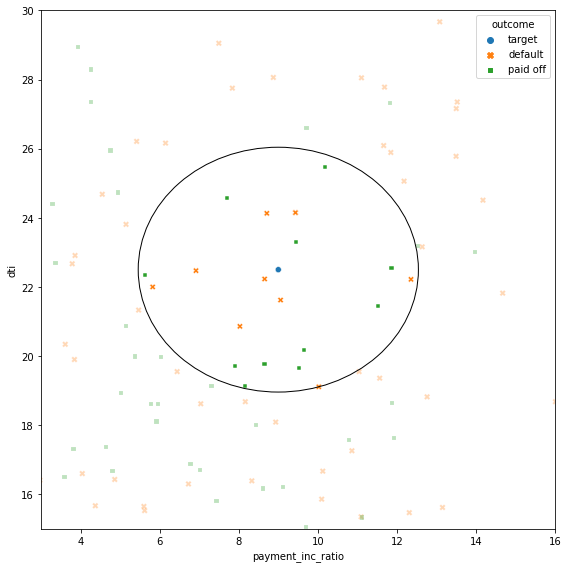

In [8]:
# [그림 6-2] 두 변수를 이용한 KNN의 대출 연체 예측
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

##### NOTE_ 
 - 분류 문제에서 KNN의 결과는 보통 이진형이지만 때로는 0과 1 사이의 확률(경향)을 결과로 줄 수 있다.
 - k개 가장 가까운 점들이 속한 클래스의 비율을 통해 확률을 정할 수 있다.
 - 확률 점수를 통해 간단한 다수결 투표 결과와는 다른 분류 규칙을 만들 수 있다.

### 6.1.2 거리 지표
 - 유사성, similarity (근접성, nearness)은 <b>거리지표</b>를 통해 결정된다.

1. <b>유클리드 거리, Euclidean distance</b>
 - 두 점 사이의 직선 거리
 - 계산상 이점이 있다.
 
 $$ \sqrt {(x_1 - u_1)^2 + (x_2 - u_2)^2 + ... + (x_p - u_p)^2} $$
 
2. <b>맨해튼 거리, Manhattan distance</b>
 - 한 번에 대각선이 아닌 한 축 방향으로만 움직일 수 있다고 할 때(도심지에서 직사각형 건물들 사이를 이동한다고 할 때_, 두 점 사이의 거리
 - 점과 점 사이의 이동 시간으로 근접성ㅇ르 따질 때 좋은 지표
 
 $$ |x_1 - u_1| + |x_2 - u_2| + ... + |x_P - u_p| $$ 
 
3. 기타 지표
 - (1) <b>마할라노비스 거리, Mahalanobis distance </b>
    - 두 변수 간 상관관계 활용
    - 계산에 공분산행렬을 사용하기 때문에 많은 계산이 필요하고 복잡성이 증가하는 단점이 있음.

### 6.1.3 원-핫 인코더
 - 요인변수를 수치형으로 변환하는 방법
 - n개 범주를 갖는 요인변수의 각 범주를 이진 가변수로 변환하여 n개 변수 생성

###### NOTE_
선형 회귀나 로지스틱 회귀에서 원-핫 인코딩은 다중공선성과 관련된 문제를 일으킨다. 이런 경우 한 가변수를 생략하는 방법이 있다.
BUT, 이 책에서 다루는 KNN이나 다른 방법에서는 이것이 문제가 되지 않는다.

### 6.1.4 표준화(정규화, z 점수)

*책에서는 표준화와 정규화를 같은 것으로 다루지만, 차이가 있음*
*책에서 다루는 것은 표준화(Standardization)이고, 정규화(Normalization)은 아래에서 따로 다루도록 함*

1.<b>표준화(Standardization)</b>
 - 정규분포의 표준화 공식으로, 어떤 특성의 값들이 정규분포를 따른다고 가정하고 값들을 평균이 0, 표준편차가 1을 갖도록 변환해주는 것
 - 변환된 결과를 일반적으로 <b>z score</b>라고 부름
 $$ z = \frac {x-\bar{x}} {s} $$
 

2. <b>정규화(Normalization)</b>
 - 다음과 같은 공식을 사용해서 특성 값의 범위를 [0, 1]로 옮기는 것
 
 $$ X^\prime = \frac {X-X_{min}} {X_{max}-X_{min}} $$



- 위 두 가지 방법을 모두 사용해보고 어느것이 더 나은지 비교하여 방법 선택

*참고자료*
*https://bskyvision.com/849*

In [9]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,...,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,...,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,...,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,...,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [10]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
loan_data

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [11]:
# 스케일링 하지 않고 fit KNN
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


KNeighborsClassifier()

In [12]:
nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [13]:
from sklearn import preprocessing

In [14]:
# 스케일링 후 fit KNN
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### 6.1.5 k 선택하기
 - k가 너무 작으면 Overfitting 문제 발생
 - k가 너무 크면 Overboosting(과대 평탄화) 문제 발생
 
 <br> 
 
 - 최적의 k값 위해 지표 활용
  - 홀드아웃 데이터 또는 타당성 검사를 위해 따로 뗴어놓은 데이터에서 정확도 측정하여 k값 결정에 사용
 
 <br> 
 
 - 노이즈가 거의 없고 아주 잘 구조화된 데이터의 경우 k값이 작을수록 잘 동작
 - 노이즈가 많은 경우 k가 클수록 좋다.
 
 <br> 
 
 - 보통 k를 1과 20 사이에 놓는다.
 - 동률이 나오는 경우를 막기 위해 보통은 홀수를 사용한다.


###### NOTE_ 편향-분산 트레이드오프(bias-variance tradeoff)
 - 과대 평탄화(오버부스팅)와 과대적합화(오버피팅) 사이의 이율배반 관계를 의미
 - 편향: 모델이 실제 세계를 정확히 표현하지 못하기 때문에 발생하는 모델링 오차를 의미
 - 유연한 모델에서 오버피팅이 발생했다면 분산이 증가했음을 의미
 - 트레이드오프를 다루기 위해 일반적으로 <b>교차타당성검사</b> 방법 활용


### 6.1.6 KNN을 통한 피처 엔지니어링
- KNN은 구현이 간단하고 직관적이지만, 성능 면에서는 경쟁력이 떨어짐
- BUT, 실용적인 측면에서 다른 분류 방법들의 특정 단계에 사용할 수 있게 모델에 '지역적 정보, local knowledge'를 추가하기 위해 활용 가능

 1. KNN은 데이터에 기반하여 분류 결과(클래스에 속할 확률)를 얻는다.
 2. 이 결과는 해당 레코드에 새로운 특징(피처)으로 추가된다. 이 결과를 다른 분류 방법에 사용한다. 원래 예측변수들(X)을 두 번씩 사용하는 셈이 된다.
 
 <br>
 
- *!다중공선성 문제를 야기시키는건 아닐까?*
 - 문제가 되지 않는다.
 - 위 2단계에서 얻은 정보는 소수의 근접한 레코드들로부터 얻은 매우 지엽적인 정보로, 새로 얻은 정보는 불필요하거나 중복성이 있지 않다.

In [15]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

loan_data

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [16]:
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [17]:
import random

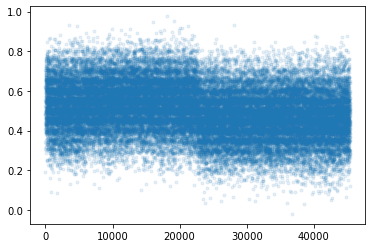

In [18]:
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')

In [19]:
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

count    45342.000000
mean         0.501104
std          0.128734
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


###### 주요개념
 - $k$-최근접 이웃(KNN) 방법이란 유사한 레코드들이 속한 클래스로 레코드를 분류하는 방법
 - 유사성(거리)은 유클리드 거리나 다른 관련 지표들을 이용해 결정
 - 가장 가까운 이웃 데이터의 개수를 의미하는 $k$는 학습 데이터에서 얼마나 좋은 성능을 보이는지를 가지고 결정
 - 일반적으로 예측변수들을 표준화(스케일링)한다. 이를 통해 스케일이 큰 변수들의 영향력이 너무 커지지 않도록 한다.
 - 예측 모델링의 첫 단계에서 종종 KNN을 사용한다. 이렇게 얻은 값을 다시 데이터에 하나의 <b>예측변수</b>로 추가해서 두 번째 단계의 (KNN이 아닌) 모델링을 위해 사용한다.

## 6.2 트리모델

- 회귀 및 분석트리(CART, classification and regression tree) = 의사결정트리(decition tree) = 트리(tree)

=======================================================================================================
###### 용어정리
 - 재귀분할(recursive partitioning): 마지막 분할 영역에 해당하는 출력이 최대한 비슷한(homogeneous) 결과를 보이도록 데이터를 반복적으로 분할하는 것
 - 분할값(split value): 분할값을 기준으로 예측변수를 그 값보다 작은 영역과 큰 영역으로 나눈다.
 - 마디(노드, node): 의사 결정 트리와 같은 가지치기 형태로 구성된 규칙들의 집합에서, 노드는 분할 규칙의 시각적인 표시라고 할 수 있다.
 - 잎(leaf): if-then 규칙의 가장 마지막 부분, 혹은 트리의 마지막 가지(Branch) 부분을 의미한다. 트리 모델에서 잎 노드는 어떤 레코드에 적용할 최종적인 분류 규칙을 의미한다.
 - 손실(loss): 분류하는 과정에서 발생하는 오분류의 수. 손실이 클수록 불순도가 높다고 할 수 있다.
 - 불순도(impurity): 데이터를 분할한 집단에서 서로 다른 클래스의 데이터가 얼마나 섞여 있는지를 나타낸다. 더 많이 섞여 있을수록 불순도가 높다고 할 수 있다.(유의어: 이질성, heterogeneity, 반의어: 동질성,homogeneity, 순도)
 - 가지치기(pruning): 학습이 끝난 트리 모델에서 오버피팅을 줄이기 위해 가지들을 하나씩 잘라내는 과정
 
=======================================================================================================

### 6.2.1 간단한 예제

In [20]:
loan3000 = pd.read_csv('C:/data/stats_for_ds/loan3000.csv') ;loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


In [21]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, textDecisionTree

In [22]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [26]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)


InvocationException: GraphViz's executables not found

In [27]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### 6.2.2 재귀 분할 알고리즘

<b>응답변수 $Y$와 $P$개의 예측변수 집합 $X_j(j=1, 2, ..., P)$가 있다고 가정하자. 어떤 파티션(분할영역) A에 대해, A를 두 개의 하위 분할 영역으로 나누기 위한 가장 좋은 재귀적 분할 방법을 찾아야 한다.</b>

1. 각 예측변수 $X_j$에 대해,
 a. $X_j$에 해당하는 각 변수 $s_j$에 대해
   i. $A$에 해당하는 모든 레코드를 $X_j < s_j$인 부분과 나머지 $X_j >= s_j$인 부분으로 나눈다.
   ii. $A$의 각 하위 분할 영역 안에 해당 클래스의 동질성을 측정한다.
 b. 하위 분할 영역 내에서의 클래스 동질성이 가장 큰 $s_j$ 값을 선택한다.
2. 클래스 동질성이 가장 큰 변수 $X_j$와 $s_j$의 값을 선택한다.

이제 알고리즘의 <b>재귀 부분</b>이 나온다.

1. 전체 데이터를 가지고 $A$를 초기화한다.
2. $A$를 두 부분 $A_1$과 $A_2$로 나누기 위해 분할 알고리즘을 적용한다.
3. $A_1$과 $A_2$ 각각에서 2번 과정을 반복한다.
4. 분할을 해도 더는 하위 분할 영역의 동질성이 개선되지 않을 정도로 충분히 분할을 진행했을 때, 알고리즘을 종료한다.

- 각 영역은 해당 여영ㄱ에 속한 응답변수들의 다수결 결과에 따라 0 또는 1로 예측 결과를 결정한다.

###### NOTE_
0 또는 1의 이진 결과 외에, 트리 모델은 하위 분할 영역에 존재하는 0과 1의 개수에 따라 확률 값을 구할 수도 있다. 간단히 분할 영역에 속하는 0 혹은 1의 개수를 전체 데이터의 개수로 나누면 구할 수 있다.

$$ P(Y=1) = \frac {파티션 내 1의 개수} {파티션의 크기} $$

이렇게 얻은 $P(Y=1)$을 통해 이진 결정을 할 수 있다. (예를들어 $Y(P=1)>0.5인 경우 1로 예측)

### 6.2.3 동질성과 불순도 측정하기
 - 각 분할 영역에 대한 동질성, 즉 <b>클래스 순도, class purity</b> 측정 방법 필요
  1. $p$를 통한 정확도 표시: 해당 파티션 내 오분류된 레코드 비율 (불순도 측정에 썩 좋지 않음)
  2. <b>지니 불순도, Gini impurity</b>: $I(A) = p(1-p)$
  3. <b>엔트로피, entropy</b>: $I(A) = -p\log_2{(p)} - (1-p)\log_2{(1-p)}$
  
###### CAUTION_ 지니계수
 - 지니불순도 != 지니계수
 - <b>지니 계수, Gini coefficient</b>: 지니불순도와 개념적으로 비슷하지만 지니 계수는 이진 분류 문제로 한정됨

### 6.2.4 트리 형성 중지하기
 - 트리가 커질수록(깊어질수록) 오버피팅의 가능성이 늘어난다. (학습데이터의 노이즈까지 학습한 결과)
 
 - 분할을 멈추는 방법
  1. 분할을 통해 얻어지는 하위 영역 또는 말단 잎의 크기가 너무 작다면 분할을 멈춘다.
  2. 새로운 분할 영역이 '유의미'한 정도로 불순도를 줄이지 않는다면 굳이 분할하지 않는다.
  
  
 - 파이썬에서 트리 복잡도 제어 방법 
  - sklearn.DecisionTree에서 복잡도 제어를 위한 인수는 'cpp_alpha'
  - GridSearchCV로 최적의 값을 찾을 수 있음
  
  - 트리 크기를 제어하는 파라미터: max_depth, min_sample_split 등등. 
  - sklearn.GridSearchCV는 모든 조합에 대한 완전 검색과 교차 검증을 결합한 편리한 방법

### 6.2.5 연속값 예측하기 (회귀)
 - 불순도 측정 방법: 하귀 분할 영역에서 편차제곱합
 - 예측 성능 평가 방법: RMSE(제곱근평균제곱오차)

### 6.2.6 트리 활용하기 
 - 블랙박스 모델이 아니라서 비전공자/다른 조직원에게 설명하기 좋음 (시각화 가능)
 
###### 주요개념
 - 의사결정트리는 결과를 분류하거나 예측하기 위한 일련의 규칙들을 생성한다.
 - 이 규칙들은 데이터를 하위 영역으로 연속적으로 분할하는 것과 관련이 있다.
 - 각 분할 혹은 분기는 어떤 한 예측변수 값을 기준으로 데이터를 위아래 두 부분으로 나누는 것이다.
 - 각 단계마다, 트리 알고리즘은 결과의 불순도를 최소화하는 쪽으로 영역 분할을 진행한다.
 - 더 이상 분할이 불가능할 때, 트리가 완전히 자랐다고 볼 수 있으며 각 말단 노드 혹은 잎 노드에 해당하는 레코드들은 단일 클래스에 속한다. 새로운 데이터는 이 규칙 경로를 따라 해당 클래스로 할당된다.